# Applying Deep Transfer Learning for NLP

Handling tough real-world problems in Natural Language Processing (NLP) include tackling with class imbalance and the lack of availability of enough labeled data for training. Thanks to the recent advancements in deep transfer learning in NLP, we have been able to make rapid strides in not only tackling these problems but also leverage these models for diverse downstream NLP tasks.

The intent of this demo session is to look at various SOTA models in deep transfer learning for NLP with hands-on examples:

- Pre-trained word embeddings for Deep Learning Models (FastText with CNNs\Bi-directional LSTMs + Attention)
- Universal Embeddings (Sentence Encoders, NNLMs)
- Transformers (BERT, DistilBERT)

We will take a benchmark classification dataset and train and compare the performance of these models. All examples here will be showcased using Python and leveraging the latest and best of TensorFlow 2.0.

# GPU Check

In [1]:
!nvidia-smi

Sun Oct 27 07:56:09 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    30W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Load Necessary Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

%matplotlib inline

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("TF Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF Version:  2.0.0
Eager mode:  True
TF Hub version:  0.6.0
GPU is available


# Load and View Dataset

In [5]:
dataset = pd.read_csv(r'https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2011%20-%20Sentiment%20Analysis%20-%20Unsupervised%20Learning/movie_reviews.csv.bz2', compression='bz2')
dataset['sentiment'] = [1 if record == 'positive' else 0 for record in dataset['sentiment']]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null int64
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [6]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# Preparing Train, Validation and Test Datasets

In [7]:
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:5000]
val_reviews = reviews [5000:10000]
test_reviews = reviews[10000:]



train_sentiments = sentiments[:5000]
val_sentiments = sentiments [5000:10000]
test_sentiments = sentiments[10000:]

train_reviews.shape, val_reviews.shape, test_reviews.shape

((5000,), (5000,), (40000,))

# Basic Text Pre-processing

In [8]:
!sudo pip3 install contractions
!sudo pip3 install textsearch
!sudo pip3 install tqdm
!sudo pip3 install nltk
!sudo pip3 install beautifulsoup4

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        doc = strip_html_tags(doc)
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        doc = contractions.fix(doc)
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, re.I|re.A)
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()  
        norm_docs.append(doc)
    return norm_docs

In [10]:
%%time

norm_train_texts = pre_process_corpus(train_reviews)
norm_val_texts = pre_process_corpus(val_reviews)
norm_test_texts = pre_process_corpus(test_reviews)

100%|██████████| 40000/40000 [00:19<00:00, 2093.93it/s]

CPU times: user 23.8 s, sys: 188 ms, total: 24 s
Wall time: 23.9 s


# 1. Pre-trained FastText Embeddings + CNN 

In [11]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_texts)
t.word_index['<PAD>'] = 0

In [12]:
print(max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      t.word_index['<UNK>'])

('unscarred', 39231) ('<PAD>', 0) 1


In [13]:
train_sequences = t.texts_to_sequences(norm_train_texts)
val_sequences = t.texts_to_sequences(norm_val_texts)
test_sequences = t.texts_to_sequences(norm_test_texts)

In [14]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=39232
Number of Documents=5000


(0, 2000)

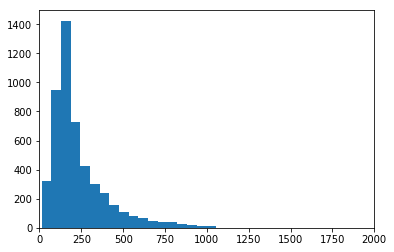

In [15]:


plt.hist([len(doc.split()) for doc in norm_train_texts], bins=30);
plt.xlim([0, 2000])

In [16]:
MAX_SEQUENCE_LENGTH = 500

# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_val = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((5000, 500), (40000, 500))

In [17]:
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300
EPOCHS=100
BATCH_SIZE=128

In [21]:
word2idx = t.word_index
FASTTEXT_INIT_EMBEDDINGS_FILE = './wiki-news-300d-1M-subword.vec'


def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):    
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*row.split(" ")) 
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore') 
                                    if len(row)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
    
    for word, idx in word_to_index.items():
        if idx >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [22]:
ft_embeddings = load_pretrained_embeddings(word_to_index=word2idx, 
                                           max_features=VOCAB_SIZE, 
                                           embedding_size=EMBED_SIZE, 
                                           embedding_file_path=FASTTEXT_INIT_EMBEDDINGS_FILE)
ft_embeddings.shape

(39232, 300)

In [23]:
# create the model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=5, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=5))

model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=5))

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=5))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          11769600  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 256)          384256    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 100, 256)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 128)          163968    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 20, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 20, 64)            41024     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 4, 64)            

In [24]:
# Fit the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(X_train, train_sentiments, 
          validation_data=(X_val, val_sentiments),
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

Train on 5000 samples, validate on 5000 samples
Epoch 1/100
5000/5000 [==============================] - 12s 2ms/sample - loss: 0.6946 - accuracy: 0.4942 - val_loss: 0.6920 - val_accuracy: 0.5564
Epoch 2/100
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.6516 - accuracy: 0.6012 - val_loss: 0.4277 - val_accuracy: 0.8154
Epoch 3/100
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.2726 - accuracy: 0.8904 - val_loss: 0.3079 - val_accuracy: 0.8708
Epoch 4/100
5000/5000 [==============================] - 10s 2ms/sample - loss: 0.0636 - accuracy: 0.9808 - val_loss: 0.4348 - val_accuracy: 0.8630
Epoch 5/100
5000/5000 [==============================] - 10s 2ms/sample - loss: 0.0082 - accuracy: 0.9976 - val_loss: 0.6429 - val_accuracy: 0.8636
Epoch 6/100
5000/5000 [==============================] - 10s 2ms/sample - loss: 6.0471e-04 - accuracy: 0.9998 - val_loss: 0.8038 - val_accuracy: 0.8738
Epoch 00006: early stopping


In [25]:

predictions = model.predict_classes(X_test, batch_size=2048, verbose=0).ravel()

print("Accuracy: %.2f%%" % (accuracy_score(test_sentiments, predictions)*100))
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions))

Accuracy: 86.40%
             precision    recall  f1-score   support

          0       0.83      0.91      0.87     20028
          1       0.90      0.81      0.86     19972

avg / total       0.87      0.86      0.86     40000



,0,1
0,18293,1735
1,3705,16267


# 2. Pre-trained FastText Embeddings + Bi-directional LSTM + Attention

In [11]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_texts)
t.word_index['<PAD>'] = 0

In [12]:
print(max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      t.word_index['<UNK>'])

('unscarred', 39231) ('<PAD>', 0) 1


In [13]:
train_sequences = t.texts_to_sequences(norm_train_texts)
val_sequences = t.texts_to_sequences(norm_val_texts)
test_sequences = t.texts_to_sequences(norm_test_texts)

In [14]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=39232
Number of Documents=5000


(0, 2000)

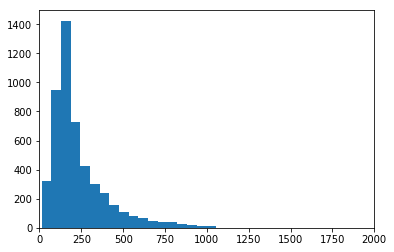

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([len(doc.split()) for doc in norm_train_texts], bins=30);
plt.xlim([0, 2000])

In [16]:
MAX_SEQUENCE_LENGTH = 500

# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_val = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((5000, 500), (40000, 500))

In [17]:
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300
EPOCHS=100
BATCH_SIZE=128

In [18]:
# define our attention layer for later
class AttentionLayer(tf.keras.layers.Layer):

    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        """

        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')

        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)

        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = tf.keras.backend.reshape(tf.keras.backend.dot(tf.keras.backend.reshape(x, 
                                                                                     (-1, features_dim)),
                                                            tf.keras.backend.reshape(self.W, 
                                                                                     (features_dim, 1))),
                                        (-1, step_dim))
        
        if self.bias:
            eij += self.b

        eij = tf.keras.backend.tanh(eij)

        a = tf.keras.backend.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= tf.keras.backend.cast(mask, tf.keras.backend.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= tf.keras.backend.cast(tf.keras.backend.sum(a, axis=1, keepdims=True) + tf.keras.backend.epsilon(), 
                                                                                    tf.keras.backend.floatx())
        a = tf.keras.backend.expand_dims(a)
        weighted_input = x * a
        
        return tf.keras.backend.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [19]:
word2idx = t.word_index
FASTTEXT_INIT_EMBEDDINGS_FILE = './wiki-news-300d-1M-subword.vec'


def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):    
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*row.split(" ")) 
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore') 
                                    if len(row)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
    
    for word, idx in word_to_index.items():
        if idx >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [20]:
ft_embeddings = load_pretrained_embeddings(word_to_index=word2idx, 
                                           max_features=VOCAB_SIZE, 
                                           embedding_size=EMBED_SIZE, 
                                           embedding_file_path=FASTTEXT_INIT_EMBEDDINGS_FILE)
ft_embeddings.shape

(39232, 300)

In [25]:
inp = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH, ))
embed = tf.keras.layers.Embedding(VOCAB_SIZE, 
                                  EMBED_SIZE, 
                                  weights=[ft_embeddings],
                                  trainable=True)(inp)
bigru = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, return_sequences=True))(embed)
attn = AttentionLayer(MAX_SEQUENCE_LENGTH)(bigru)
dense1 = tf.keras.layers.Dense(256, activation='relu')(attn)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)
outp = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.models.Model(inputs=inp, outputs=outp)
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 300)          11769600  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 512)          1140736   
_________________________________________________________________
attention_layer_1 (Attention (None, 512)               1012      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               6579

In [26]:
# Fit the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(X_train, train_sentiments, 
          validation_data=(X_val, val_sentiments),
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

Train on 5000 samples, validate on 5000 samples
Epoch 1/100
5000/5000 [==============================] - 22s 4ms/sample - loss: 0.6897 - accuracy: 0.5374 - val_loss: 0.6737 - val_accuracy: 0.5184
Epoch 2/100
5000/5000 [==============================] - 18s 4ms/sample - loss: 0.5334 - accuracy: 0.7374 - val_loss: 0.3528 - val_accuracy: 0.8486
Epoch 3/100
5000/5000 [==============================] - 18s 4ms/sample - loss: 0.1841 - accuracy: 0.9344 - val_loss: 0.3331 - val_accuracy: 0.8708
Epoch 4/100
5000/5000 [==============================] - 18s 4ms/sample - loss: 0.0556 - accuracy: 0.9814 - val_loss: 0.4700 - val_accuracy: 0.8590
Epoch 5/100
5000/5000 [==============================] - 18s 4ms/sample - loss: 0.0170 - accuracy: 0.9952 - val_loss: 0.5902 - val_accuracy: 0.8546
Epoch 6/100
5000/5000 [==============================] - 18s 4ms/sample - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.6845 - val_accuracy: 0.8668
Epoch 00006: early stopping


In [27]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict(X_test, batch_size=512, verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(test_sentiments, predictions)*100))
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions))

Accuracy: 86.43%
             precision    recall  f1-score   support

          0       0.84      0.91      0.87     20028
          1       0.90      0.82      0.86     19972

avg / total       0.87      0.86      0.86     40000



,0,1
0,18189,1839
1,3588,16384


# 3. Google's Universal Sentence Encoder

In [6]:
train_reviews[:3]

array(["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to

In [7]:
tf.compat.v1.disable_eager_execution()

In [8]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(module_url, trainable=True)

In [9]:
with tf.compat.v1.Session() as session:
    session.run([tf.compat.v1.global_variables_initializer(), 
                 tf.compat.v1.tables_initializer()])
    message_embeddings = session.run(embed(train_reviews[:3]))

message_embeddings, message_embeddings.shape

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


(array([[-0.02637997,  0.07631321, -0.01577696, ..., -0.0692173 ,
         -0.04053345,  0.08181424],
        [ 0.04789976,  0.02754292,  0.01141358, ..., -0.00466745,
          0.02187275,  0.05876644],
        [-0.02861057,  0.02973452, -0.02516095, ..., -0.04818085,
          0.05127342,  0.10013439]], dtype=float32), (3, 512))

In [10]:
def UniversalSentenceEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))

In [11]:
input_text = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
embedding = tf.keras.layers.Lambda(UniversalSentenceEmbedding, output_shape=(512, ))(input_text)
dense1 = tf.keras.layers.Dense(256, activation='relu')(embedding)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)
pred = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)
model = tf.keras.models.Model(inputs=[input_text], outputs=pred)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda (Lambda)              (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257   

In [12]:
EPOCHS=100
BATCH_SIZE=128

In [13]:
# Fit the model
with tf.compat.v1.Session() as session:
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)
    
    model.fit(train_reviews, train_sentiments, 
              validation_data=(val_reviews, val_sentiments),
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              shuffle=True,
              callbacks=[es],
              verbose=1)
    
    model.save_weights('./use_model.h5')

Train on 5000 samples, validate on 5000 samples
Epoch 1/100
5000/5000 [==============================] - 22s 4ms/sample - loss: 0.4879 - accuracy: 0.7762 - val_loss: 0.3804 - val_accuracy: 0.8326
Epoch 2/100
5000/5000 [==============================] - 20s 4ms/sample - loss: 0.3610 - accuracy: 0.8356 - val_loss: 0.3692 - val_accuracy: 0.8358
Epoch 3/100
5000/5000 [==============================] - 20s 4ms/sample - loss: 0.3443 - accuracy: 0.8474 - val_loss: 0.3643 - val_accuracy: 0.8394
Epoch 4/100
5000/5000 [==============================] - 20s 4ms/sample - loss: 0.3348 - accuracy: 0.8538 - val_loss: 0.3643 - val_accuracy: 0.8400
Epoch 5/100
5000/5000 [==============================] - 20s 4ms/sample - loss: 0.3260 - accuracy: 0.8534 - val_loss: 0.3645 - val_accuracy: 0.8394
Epoch 6/100
5000/5000 [==============================] - 20s 4ms/sample - loss: 0.3209 - accuracy: 0.8534 - val_loss: 0.3593 - val_accuracy: 0.8398
Epoch 7/100
5000/5000 [==============================] - 20s 4ms

In [14]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(module_url, trainable=False)

def UniversalSentenceEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))

input_text = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
embedding = tf.keras.layers.Lambda(UniversalSentenceEmbedding, output_shape=(512, ))(input_text)
dense1 = tf.keras.layers.Dense(256, activation='relu')(embedding)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)
pred = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)
model = tf.keras.models.Model(inputs=[input_text], outputs=pred)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Final evaluation of the model
with tf.compat.v1.Session() as session:
    session.run(tf.compat.v1.global_variables_initializer())
    session.run(tf.compat.v1.tables_initializer())
    
    model.load_weights('./use_model.h5')
    
    predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict(test_reviews, batch_size=512, verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(test_sentiments, predictions)*100))
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions))

Accuracy: 83.69%
             precision    recall  f1-score   support

          0       0.84      0.84      0.84     20028
          1       0.84      0.84      0.84     19972

avg / total       0.84      0.84      0.84     40000



,0,1
0,16750,3278
1,3248,16724


# 4. Neural Network Language Model

In [10]:
norm_train_texts[:3]

array(['one of the other reviewers has mentioned that after watching just 1 oz episode you will be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows would not dare for

In [11]:
model = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(model, output_shape=[128], input_shape=[], 
                           dtype=tf.string, trainable=True)
print(hub_layer(norm_train_texts[:3]))

tf.Tensor(
[[ 2.1637728   0.18443683  0.33868548  0.18714745  0.22127508  0.03885808
   0.20959312 -0.31841168 -0.2998969   0.06570792  0.29815578 -0.36403018
  -0.36856505 -0.36688802 -0.15620337  0.12879042 -0.5279176  -0.05068737
  -0.5405576   1.0036108   0.0983031   0.13588336 -0.24809034 -0.25477773
   0.10724348 -0.25031033  0.2962077  -0.00750021 -0.20377205  0.14243263
   0.07617488  0.1518155   0.17101593  0.02466883  0.36238325 -0.12907393
  -0.24922621 -0.41444957  0.10826241  0.50078815 -0.4214459  -0.1228352
  -0.12632468 -0.10329366  0.22902705  0.31700385  0.08330556  0.16459242
  -0.08031587  0.02723667  0.11583095  0.03190616 -0.06533278  0.31237805
  -0.24900854 -0.0130042   0.06682863 -0.26658732 -0.06602515  0.04475337
  -0.5149443   0.17992204  0.05797209 -0.40984443 -0.01934146  0.15096185
   0.17236525 -0.46626076  0.32511476 -0.0269111  -0.45234472  0.2429736
   0.00959222 -0.1835455  -0.10930699  0.40188032 -0.01052749 -0.5940521
  -0.18280017  0.141591    0.1

In [12]:
model = tf.keras.models.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 124,675,841
Trainable params: 124,675,841
Non-trainable params: 0
__________________________________________

In [13]:
EPOCHS=100
BATCH_SIZE=128

In [14]:
# Fit the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)
    
model.fit(norm_train_texts, train_sentiments, 
          validation_data=(norm_val_texts, val_sentiments),
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

Train on 5000 samples, validate on 5000 samples
Epoch 1/100
5000/5000 [==============================] - 3s 581us/sample - loss: 0.6631 - accuracy: 0.6354 - val_loss: 0.6199 - val_accuracy: 0.7496
Epoch 2/100
5000/5000 [==============================] - 2s 328us/sample - loss: 0.5888 - accuracy: 0.7654 - val_loss: 0.5592 - val_accuracy: 0.7700
Epoch 3/100
5000/5000 [==============================] - 2s 328us/sample - loss: 0.5217 - accuracy: 0.8026 - val_loss: 0.5047 - val_accuracy: 0.7952
Epoch 4/100
5000/5000 [==============================] - 2s 329us/sample - loss: 0.4613 - accuracy: 0.8294 - val_loss: 0.4550 - val_accuracy: 0.8202
Epoch 5/100
5000/5000 [==============================] - 2s 331us/sample - loss: 0.4083 - accuracy: 0.8530 - val_loss: 0.4340 - val_accuracy: 0.8132
Epoch 6/100
5000/5000 [==============================] - 2s 327us/sample - loss: 0.3657 - accuracy: 0.8700 - val_loss: 0.3912 - val_accuracy: 0.8426
Epoch 7/100
5000/5000 [==============================] - 2

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions = model.predict_classes(norm_test_texts, batch_size=512, verbose=0).ravel()

print("Accuracy: %.2f%%" % (accuracy_score(test_sentiments, predictions)*100))
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions))

Accuracy: 86.52%
             precision    recall  f1-score   support

          0       0.87      0.86      0.86     20028
          1       0.86      0.87      0.87     19972

avg / total       0.87      0.87      0.87     40000



,0,1
0,17201,2827
1,2567,17405


# 5. BERT (Bi-directional Encoder Representations from Transformers)

In [2]:
!sudo pip3 install tqdm
!sudo pip3 install transformers

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
import matplotlib.pyplot as plt

%matplotlib inline

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF Version:  2.0.0
Eager mode:  True
GPU is available


In [6]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
import tqdm

def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks, all_segments= [], [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        tokens = tokenizer.tokenize(doc)
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
        segments = [0] * max_seq_length
        all_ids.append(ids)
        all_masks.append(masks)
        all_segments.append(segments)
    encoded = np.array([all_ids, all_masks, all_segments])
    return encoded

In [8]:
MAX_SEQ_LENGTH = 500

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inp_segment = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_segment_ids")
inputs = [inp_id, inp_mask, inp_segment]

hidden_state = transformers.TFBertModel.from_pretrained('bert-base-uncased')(inputs)
pooled_output = hidden_state[1]
dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)
output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                           epsilon=1e-08), 
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bert_input_ids (InputLayer)     [(None, 500)]        0                                            
__________________________________________________________________________________________________
bert_input_masks (InputLayer)   [(None, 500)]        0                                            
__________________________________________________________________________________________________
bert_segment_ids (InputLayer)   [(None, 500)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 500, 768), ( 109482240   bert_input_ids[0][0]             
                                                                 bert_input_masks[0][0]       

In [9]:
train_features_ids, train_features_masks, train_features_segments = create_bert_input_features(tokenizer, 
                                                                                               train_reviews, 
                                                                                               max_seq_length=MAX_SEQ_LENGTH)
val_features_ids, val_features_masks, val_features_segments = create_bert_input_features(tokenizer, 
                                                                                         val_reviews, 
                                                                                         max_seq_length=MAX_SEQ_LENGTH)
#test_features = create_bert_input_features(tokenizer, test_reviews, max_seq_length=MAX_SEQ_LENGTH)
print('Train Features:', train_features_ids.shape, train_features_masks.shape, train_features_segments.shape)
print('Val Features:', val_features_ids.shape, val_features_masks.shape, val_features_segments.shape)

Converting docs to features: 100%|██████████| 5000/5000 [00:21<00:00, 233.26it/s]


Train Features: (5000, 500) (5000, 500) (5000, 500)
Val Features: (5000, 500) (5000, 500) (5000, 500)


In [10]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=1,
                                      restore_best_weights=True,
                                      verbose=1)
model.fit([train_features_ids, 
           train_features_masks, 
           train_features_segments], train_sentiments, 
          validation_data=([val_features_ids, 
                            val_features_masks, 
                            val_features_segments], val_sentiments),
          epochs=3, 
          batch_size=13, 
          callbacks=[es],
          shuffle=True,
          verbose=1)

Train on 5000 samples, validate on 5000 samples
Epoch 1/3
5000/5000 [==============================] - 817s 163ms/sample - loss: 0.4041 - accuracy: 0.8044 - val_loss: 0.2311 - val_accuracy: 0.9030
Epoch 2/3
5000/5000 [==============================] - 794s 159ms/sample - loss: 0.1778 - accuracy: 0.9400 - val_loss: 0.2054 - val_accuracy: 0.9162
Epoch 3/3
5000/5000 [==============================] - 794s 159ms/sample - loss: 0.0921 - accuracy: 0.9722 - val_loss: 0.2928 - val_accuracy: 0.9126
Epoch 00003: early stopping


In [12]:
model.save_weights('bert_ft_wts.h5')

In [11]:
test_features_ids, test_features_masks, test_features_segments = create_bert_input_features(tokenizer, 
                                                                                            test_reviews, 
                                                                                            max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape, test_features_segments.shape)

Converting docs to features: 100%|██████████| 40000/40000 [02:42<00:00, 246.87it/s]

Test Features: (40000, 500) (40000, 500) (40000, 500)


In [14]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict([test_features_ids, 
                                            test_features_masks, 
                                            test_features_segments], verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(test_sentiments, predictions)*100))
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions))

Accuracy: 91.83%
             precision    recall  f1-score   support

          0       0.90      0.94      0.92     20028
          1       0.94      0.90      0.92     19972

avg / total       0.92      0.92      0.92     40000



,0,1
0,18836,1192
1,2076,17896


# 6. DistilBERT 

In [7]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [8]:
import tqdm

def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks = [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        tokens = tokenizer.tokenize(doc)
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
        all_ids.append(ids)
        all_masks.append(masks)
    encoded = np.array([all_ids, all_masks])
    return encoded

In [9]:
MAX_SEQ_LENGTH = 500

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inputs = [inp_id, inp_mask]

hidden_state = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')(inputs)[0]
pooled_output = hidden_state[:, 0]    
dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)
output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)


model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                           epsilon=1e-08), 
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bert_input_ids (InputLayer)     [(None, 500)]        0                                            
__________________________________________________________________________________________________
bert_input_masks (InputLayer)   [(None, 500)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 500, 768),)  66362880    bert_input_ids[0][0]             
                                                                 bert_input_masks[0][0]           
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 768)]        0           tf_distil_bert_model[0][0]   

In [10]:
train_features_ids, train_features_masks = create_bert_input_features(tokenizer, train_reviews, 
                                                                      max_seq_length=MAX_SEQ_LENGTH)
val_features_ids, val_features_masks = create_bert_input_features(tokenizer, val_reviews, 
                                                                  max_seq_length=MAX_SEQ_LENGTH)
#test_features = create_bert_input_features(tokenizer, test_reviews, max_seq_length=MAX_SEQ_LENGTH)
print('Train Features:', train_features_ids.shape, train_features_masks.shape)
print('Val Features:', val_features_ids.shape, val_features_masks.shape)

Converting docs to features: 100%|██████████| 5000/5000 [00:21<00:00, 230.66it/s]

Train Features: (5000, 500) (5000, 500)
Val Features: (5000, 500) (5000, 500)


In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=1,
                                      restore_best_weights=True,
                                      verbose=1)
model.fit([train_features_ids, 
           train_features_masks], train_sentiments, 
          validation_data=([val_features_ids, 
                            val_features_masks], val_sentiments),
          epochs=3, 
          batch_size=20, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

Train on 5000 samples, validate on 5000 samples
Epoch 1/3
5000/5000 [==============================] - 394s 79ms/sample - loss: 0.3757 - accuracy: 0.8196 - val_loss: 0.2251 - val_accuracy: 0.9112
Epoch 2/3
5000/5000 [==============================] - 386s 77ms/sample - loss: 0.1798 - accuracy: 0.9376 - val_loss: 0.2429 - val_accuracy: 0.9074
Epoch 00002: early stopping


In [12]:
model.save_weights('distillbert_ft_wts.h5')

In [13]:
test_features_ids, test_features_masks = create_bert_input_features(tokenizer, test_reviews, 
                                                                    max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape)

Converting docs to features: 100%|██████████| 40000/40000 [02:43<00:00, 243.96it/s]


Test Features: (40000, 500) (40000, 500)


In [17]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict([test_features_ids, 
                                            test_features_masks], batch_size=200, verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(test_sentiments, predictions)*100))
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions))

Accuracy: 90.71%
             precision    recall  f1-score   support

          0       0.90      0.91      0.91     20028
          1       0.91      0.90      0.91     19972

avg / total       0.91      0.91      0.91     40000



,0,1
0,18248,1780
1,1937,18035
